# Analysis of automatic synaptic prediction

The automatic synaptic prediction was done by an algorithm published in Buhmann et al., and retrieved from FlyWire using the FAFBseq-py package.

In [105]:
#Importing packages
#import navis
import fafbseg
#from fafbseg import flywire
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
#from caveclient import CAVEclient
#from visualizations.helpers.synapse_queries import combine_xyz, separate_xyz, synapse_count

#client = CAVEclient('flywire_fafb_production')

In [107]:
#Plots settings

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}
axes = {'labelsize': 16, 'titlesize': 16}
ticks = {'labelsize': 14}
legend = {'fontsize': 14}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

cm = 1/2.54  # centimeters in inches

## A) Proofreading predicted synapses via annotations

In [ ]:
# For debuggin purposes
#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5574105810075648'# OLD URL
#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6667315345096704'# UPDATED URL
URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6516888544739328' # No segments in the dict
dict_URL = fafbseg.flywire.decode_url(URL)

In [219]:
# Manually loading the URL containing synapses as annotations and notes in each

URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4934928156327936' # All FN checked here
dict_URL = fafbseg.flywire.decode_url(URL)

In [245]:
URL_ls = ['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4934928156327936', 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4571711703875584']

In [246]:
URL_ls

['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4934928156327936',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4571711703875584']

### 1. Loading URLs from excell file

In [232]:
# Loading the URLs from an excel file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileDate = '20230222'
fileName = f'All_Tm9_neurons_input_count_ME_R_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)


In [233]:
# Filtering
URL_df = df[df['Synapses proofread (Y/N)'] == 'Y'].copy() # To take only links with proofread synapses

In [234]:
#Extracting URLs in a list
URL_ls = URL_df ['URL buhmann postsynapses (annotate only as: true, false or false negative)']
URL_ls = URL_ls[URL_ls.notnull()] # Getting rid of NaNs 


### 2. Extracting annotations' labels / comments

In [247]:
# Extracting points and labels/descriptions
points = []
descriptions = []
segment_ids = []
faulty_URLs = []

for URL in URL_ls:
    dict_URL = fafbseg.flywire.decode_url(URL)
    for ann in dict_URL['annotations']:
        if 'point' in ann.keys():
            try: 
                segment_ids.append(ann['segments'])
            except:# dealing with faulty URLs with no data inside
                faulty_URLs.append(URL)
                continue
            try:
                descriptions.append(ann['description'])
            except: # dealing with faulty URLs with no data inside
                descriptions.append('NO DESCRIPTION YET')
        
            points.append(ann['point'])
            
# Splitting in pre and post IDs
pre = []
post = []
for pair in segment_ids:
    pre.append(pair[0])
    post.append(pair[1])   
    
#  len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ]) # Brief count of true synapses

In [248]:
# Creating the summary data frame
proofread_synapses_df = pd.DataFrame()
proofread_synapses_df['post_pt_position'] = points
proofread_synapses_df['proofread_label'] = descriptions
proofread_synapses_df['pre_id'] = pre
proofread_synapses_df['post_id'] = post
display(proofread_synapses_df.head())

,post_pt_position,proofread_label,pre_id,post_id
0,"[66659, 85714, 5406]",true\n,720575940659388801,720575940627738884
1,"[66885, 85749, 5367]",true\n,720575940659388801,720575940627738884
2,"[67681, 86266, 5435]",true,720575940659388801,720575940627738884
3,"[67124, 86454, 5390]",true,720575940659388801,720575940627738884
4,"[67664, 86251, 5434]",true,720575940659388801,720575940627738884


In [249]:
# Check if there was any faulta URL
print(f'Number of URLs with no or faulty data: {len(faulty_URLs)}')
display(faulty_URLs)

Number of URLs with no or faulty data: 0


[]

In [250]:
#Prints summaries of what is in the data
print(f'Total number of rows: {len(df)}')
print(f'Total number of links to analyze: {len(URL_ls)}')
print(f'Links for {round((len(URL_ls)/len(df))*100,2)} % of the data ')
print(f'Number of URLs with no/faulty data: {len(faulty_URLs)}')
print(f"Number of points with no description: {len(proofread_synapses_df[proofread_synapses_df['proofread_label']== 'NO DESCRIPTION YET'])}")

Total number of rows: 1351
Total number of links to analyze: 2
Links for 0.15 % of the data 
Number of URLs with no/faulty data: 0
Number of points with no description: 0


### 3. Quantifiying annotation proofread status

In [251]:
#Unique descriptions
proofread_synapses_df['proofread_label'].unique()

array(['true\n', 'true', 'most likely true\n', 'false (redundant)',
       'false pos. (redundant)', 'false', 'most likely true',
       'probably true', 'false negative', 'false negative\n',
       'maybe false negative',
       'false positive (wouldn´t count this one)\n', 'false negtive'],
      dtype=object)

In [252]:
#Aggregating descriptions

new_description_ls = []
for d in descriptions:
    if 'maybe' in d.lower() or 'prob' in d.lower() or 'likely' in d.lower() or 'could' in d.lower() or 'buggy' in d.lower() or 'hard' in d.lower():
        new_description_ls.append('N.I.') # N.I. = undecided
    elif 'false neg'in d.lower():
        new_description_ls.append('FN') # FN = False negative
    elif 'ant' in d.lower(): #'ant' for different missspellings of redundant
        new_description_ls.append('R') # R = False positive redundant
    elif 'true' in d.lower():
        new_description_ls.append('TP')# TP = True positive
    elif 'false' in d.lower():
        new_description_ls.append('FP') # FP = False positive
    elif 'NO DESCRIPTION' in d:
        new_description_ls.append('ND') # ND = 'NO DESCRIPTION YET'
    else:
        new_description_ls.append(d)
    
proofread_synapses_df['proofread_label'] = new_description_ls


In [253]:
#Creating summary Data Frame

#Groupying by label
labels_df = pd.DataFrame(proofread_synapses_df.groupby('proofread_label').size())
labels_df.rename(columns={0: 'count'}, inplace=True)

#Adding data
labels_df['percentatge'] = round((labels_df['count']/labels_df['count'].sum())*100,2)


In [254]:
# Same data frame without redundant synapses
NO_R_percentatge = []
NO_R_total_count = labels_df['count'].sum() - labels_df.loc['R']['count']
for idx, count in labels_df['count'].iteritems():
    if idx == 'R':
        NO_R_percentatge.append(0.0)
        continue
    
    #Calculating percentage
    temp_percent = round((count/NO_R_total_count)*100,2)
    NO_R_percentatge.append(temp_percent)

labels_df['new_percentatge']= NO_R_percentatge
display(labels_df)

,count,percentatge,new_percentatge
proofread_label,,,
FN,13,15.66,16.25
FP,2,2.41,2.50
N.I.,6,7.23,7.50
R,3,3.61,0.00
TP,59,71.08,73.75


In [255]:
# Printing some information
buhmann_sensitivity = round((labels_df.loc['TP']['count']/(labels_df.loc['TP']['count'] + labels_df.loc['FN']['count']))*100,2)
print(f'The sensitivity is: {buhmann_sensitivity}' )

The sensitivity is: 81.94


Text(0.5, 1.0, 'Buhmann synapses proofreading')

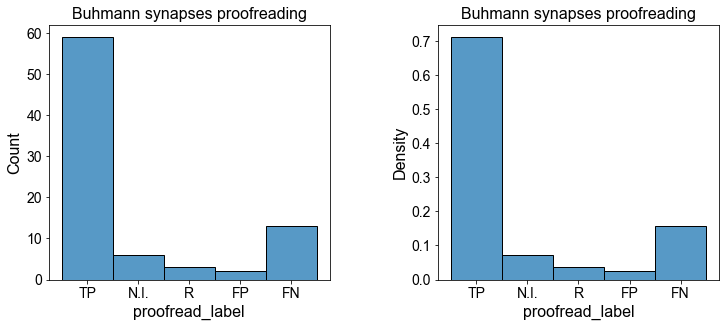

In [256]:
# Plotting analysis
fig, axs = plt.subplots(nrows= 1, ncols=2, figsize=(30*cm, 15*cm))
fig.tight_layout(pad=6) # Adding some space between subplots

#Axis: Counts
sns.histplot(data = proofread_synapses_df, x = 'proofread_label', ax=axs[0], stat="count", common_norm=False)
axs[0].set_title('Buhmann synapses proofreading')

#Another axis: density
sns.histplot(data = proofread_synapses_df, x = 'proofread_label', ax=axs[1], stat="density", common_norm=True)
axs[1].set_title('Buhmann synapses proofreading')

